In [20]:
from util import *
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os
import datetime

# Load Data
Loading from preprocessed numpy array

# Creating GAN

In [29]:
class LSTMGAN():
    def __init__(self, step_i, step_o, data):
        self.feature_len = data.shape[2] 
        self.input_data, self.output_data = split_input_output(step_i, step_o, data)
        self.step_input = self.input_data.shape[1]
        self.step_output = self.output_data.shape[1]
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        prediction = model(noise)

        return Model(noise, prediction)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        prediction = Input(shape=self.dis_shape)
        validity = model(prediction)

        return Model(prediction, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=1000, log_interval=None):
    
        start_time = datetime.datetime.now()

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)
        
        print("start training....")

        for epoch in range(epochs):
            idx = np.random.randint(0, self.input_data.shape[0], batch_size)
            real_input= self.input_data[idx]
            real_output= self.output_data[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_transform(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)

            # Plot the progress
            if log_interval and epoch % log_interval == 0:
                cur_time = datetime.datetime.now()
                print ("epoch %d ------------------------------------------------------" % epoch)
                print( "D loss: %f, acc.: %.2f%%, G loss: %f" % (d_loss[0], 100*d_loss[1], g_loss))
                print("time elapsed : ", cur_time - start_time)
                print("input:\n", scalers[0].inverse_transform( real_input[0]))
                print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
                print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # If at save interval => save model
            if (epoch + 1) % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

In [10]:
data = load_data("./data_stock/Dowjones_average.csv")
step_i = 5
step_o = 1
grouped_data = group_time_series(step_i + step_o, data)

lstmgan = LSTMGAN(step_i, step_o , grouped_data)
lstmgan.train(epochs=5000, batch_size=50, save_interval=1000, log_interval=1000)

start training....
epoch 0 ------------------------------------------------------
D loss: 6.812597, acc.: 50.00%, G loss: 6.712723
time elapsed :  0:00:15.089977
input:
 [[27925.23 27925.23 27464.9  27500.89]
 [27711.71 28206.21 27704.54 27940.47]
 [28022.51 28174.78 27447.08 27534.58]
 [27613.86 27828.82 27448.15 27665.64]
 [27718.74 28086.06 27718.74 27993.33]]
fake_output:
 [[27797.158 28045.621 27554.9   27725.22 ]]
real_output:
 [[28139.76 28231.06 27931.45 27995.6 ]]
epoch 1000 ------------------------------------------------------
D loss: 0.720782, acc.: 46.33%, G loss: 1.796555
time elapsed :  0:03:37.349673
input:
 [[28533.61 28676.29 28440.63 28586.9 ]
 [28671.12 28957.9  28659.67 28837.52]
 [28764.95 28808.84 28604.35 28679.81]
 [28731.3  28792.56 28461.73 28514.  ]
 [28323.4  28535.85 28181.54 28494.2 ]]
fake_output:
 [[28132.527 28157.957 27798.277 27988.645]]
real_output:
 [[28570.72 28842.9  28570.72 28606.31]]
epoch 2000 -------------------------------------------------

# Generate Stock Prices
Generating random input and letting model predict output

In [21]:
# import util
# import importlib
# importlib.reload(util)
# from util import *

(real_input, real_output) =  split_input_output(step_i, step_o, grouped_data)
(stzd_input, scalers) = batch_standardize(real_input)
stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()
pred_output = batch_inverse_transform(stzd_pred_output, scalers)
stzd_real_output = batch_transform(real_output, scalers)

MA5 = moving_average(5, data)
MA5 = MA5[:len(real_input) * step_o].reshape(-1, step_o, MA5.shape[-1])
stzd_MA5 = batch_transform(MA5, scalers)

print(f'predicted price:\n{pred_output[0]},\nreal price:\n{real_output[0]},\nMA5:\n{MA5[0]} \
       ,\nstandardized predicted price:\n{stzd_pred_output[0]} \
       ,\nstandardized real price:\n{stzd_real_output[0]} \
       ,\nstandardized MA5:\n{stzd_MA5[0]}')

predicted price:
[[18889.959 19305.29  18348.049 18794.674]],
real price:
[[19722.19 20737.7  19649.25 20704.91]],
MA5:
[[19957.452 20392.716 19056.954 19797.88 ]]        ,
standardized predicted price:
[[-2.0928552 -1.5017352 -1.3266969 -1.1202705]]        ,
standardized real price:
[[-0.4612385   0.47642245  1.10846713  1.01287107]]        ,
standardized MA5:
[[0. 0. 0. 0.]]


# Plot


In [18]:
titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)

#transform everything into columns                
stzd_pred_data = columnify(stzd_pred_output)
stzd_real_data = columnify(stzd_real_output)
stzd_MA5_data = columnify(stzd_MA5)
pred_data = columnify(pred_output)
real_data = columnify(real_output) 
MA5_data = columnify(MA5)

pred_metrics = metrics(real_data[3],pred_data[3])

MA5_metrics = metrics(real_data[3],MA5_data[3])

print('LSTM: MAE=',pred_metrics['MAE'],'RMSE=',pred_metrics['RMSE'],'MAPE=',pred_metrics['MAPE'],'AR=',pred_metrics['AR'])
print('MA5: MAE=', MA5_metrics['MAE'],'RMSE=',MA5_metrics['RMSE'],'MAPE=',MA5_metrics['MAPE'],'AR=',MA5_metrics['AR'])


LSTM: MAE= 210.6765961021504 RMSE= 295.55823862498283 MAPE= 0.007227376562207871 AR= 33.51114224137929
MA5: MAE= 354.6332860215055 RMSE= 485.47843553596863 MAPE= 0.012149599237883172 AR= 6.924116379310292


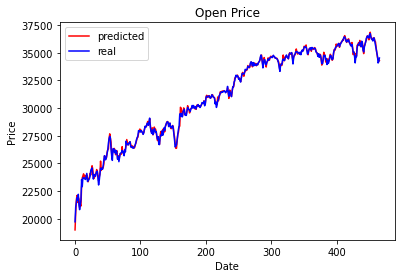

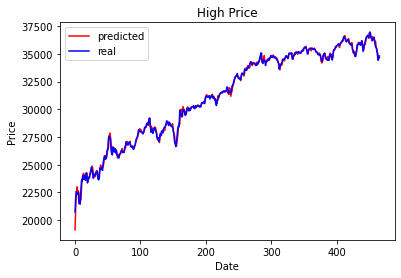

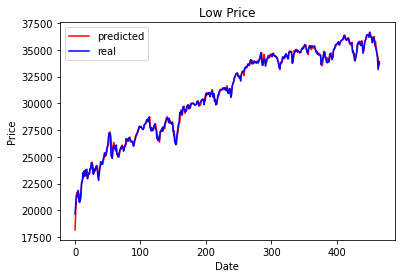

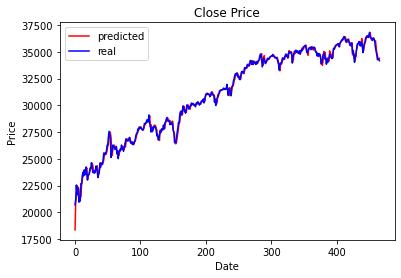

In [93]:
for i in range(columns):
    length = len(pred_data[i])
    plt.plot(range(length), pred_data[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), real_data[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()

In [ ]:
def validate_LSTM(step_i, step_o, train_data, test_data):
    lstmgan = LSTMGAN(step_i, step_o , train_data)
    lstmgan.train(epochs=5000, batch_size=50, save_interval=1000)
    
    (real_input, real_output) =  split_input_output(step_i, step_o, test_data)
    (stzd_input, scalers) = batch_standardize(real_input)
    stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()
    pred_output = batch_inverse_transform(stzd_pred_output, scalers)
    stzd_real_output = batch_transform(real_output, scalers)
    
    #transform into columns                
    pred_data = columnify(pred_output)
    real_data = columnify(real_output) 

    return (metrics(real_data[0],pred_data[0]),
            metrics(real_data[1],pred_data[1]),
            metrics(real_data[2],pred_data[2]),
            metrics(real_data[3],pred_data[3]))

def k_fold_validate(step_i, step_o, num_fold, data):
    metrics_list = []
    folds = k_fold_index_split(len(data), num_fold)
    for i in range(0, num_fold):
        f = folds[i]
        print(f"validation fold {i}: ")
        train_data = np.delete(data, f, 0)
        test_data = data[f]
        metrics = validate_LSTM(step_i, step_o, train_data, test_data)
        print(metrics)
        metrics_list.append(metrics)
    
    return validation

validation = k_fold_validate(step_i, step_o, 10, grouped_data)

validation fold 0: 
start training....
({'MAE': 125.99576130319149, 'RMSE': 185.00492946173873, 'MAPE': 0.004283193503634756, 'AR': 2320.445869565217}, {'MAE': 220.1765724734047, 'RMSE': 308.7861088159118, 'MAPE': 0.007394961231062272, 'AR': 2313.328043478261}, {'MAE': 251.80059009308513, 'RMSE': 310.73183204030465, 'MAPE': 0.008483252645055386, 'AR': 2359.8476086956525}, {'MAE': 295.60726728723404, 'RMSE': 402.3067993461281, 'MAPE': 0.010071289170373952, 'AR': 2302.7889130434783})
validation fold 1: 
start training....
({'MAE': 153.44563497340448, 'RMSE': 259.78711570644344, 'MAPE': 0.005470552780482223, 'AR': 2246.6941304347824}, {'MAE': 215.2487184175535, 'RMSE': 296.8478340560754, 'MAPE': 0.007432091283002544, 'AR': 2244.3980434782616}, {'MAE': 280.4854421542553, 'RMSE': 411.95633883512716, 'MAPE': 0.00972018061362802, 'AR': 2282.842173913043}, {'MAE': 297.71977726063807, 'RMSE': 431.58444637748636, 'MAPE': 0.01021887843198968, 'AR': 2268.0915217391307})
validation fold 2: 
start t